In [1]:
from bs4 import BeautifulSoup # BeautifulSoup is in bs4 package 
import requests
import re # Regular expressions
from collections import Counter # Keep track of our term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline

In [43]:
def text_cleaner(website):
    '''
    This function just cleans up the raw html so that I can look at it.
    Inputs: a URL to investigate
    Outputs: Cleaned text only
    '''
    try:
        content = requests.get(website) 
    except: 
        return   # Need this in case the website isn't there anymore or some other weird connection problem 
    
    soup_obj = BeautifulSoup(content.text, 'html.parser') # Get the html from the site
    
    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
    

    text = soup_obj.get_text() # Get the text from this
    
        
    
    lines = (line.strip() for line in text.splitlines()) # break into lines
    
        
        
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each
    
    def chunk_space(chunk):
        chunk_out = chunk + ' ' # Need to fix spacing issue
        return chunk_out  
        
    
    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends of line
        
        
    # Now clean out all of the unicode junk (this line works great!!!)
        
    try:
        text = text.decode('unicode_escape') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception
       
      
    text = re.sub("[^(a-zA-Z\\a-zA-Z)][^a-zA-Z.+3#]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
                                                # Also include + for C++
        
       
    text = text.lower().split()  # Go to lower case and split them apart   
        
        
    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
                            # or not on the website)
        
    return text

In [44]:
result = text_cleaner('https://www.indeed.com/viewjob?jk=d4906e2c17725bc2&tk=1easqk7ea2vih000&from=serp&vjs=3d')

In [45]:
result

['to',
 'believe',
 'user-centered',
 'analytics',
 'vitamins.',
 'tangible',
 'still',
 '(i.e.',
 'love',
 'find',
 'scratch.',
 'other',
 'fair',
 'usability',
 'level.',
 'fruits',
 'remote,',
 'hands-on',
 'product',
 'portfolio',
 'labcareer',
 'salaries',
 'based',
 'surveys,',
 '/',
 'ideas',
 '(preferred)',
 'excellent',
 'nyuser',
 'pioneering',
 'nowapply',
 'teams',
 'truly',
 'strive',
 'technologies',
 'architecture,',
 'ambiguous',
 'but',
 'consumer',
 '5+',
 'them',
 'environment',
 'time,',
 'complex',
 'will',
 'ny',
 'projects',
 'guiding',
 'multivariate',
 'companiessalariesfind',
 'demonstrates',
 'document',
 'passionate',
 'gain',
 'drinks,',
 'by',
 'skills',
 'way',
 'marketers',
 'over',
 'advocate',
 'in|employers',
 'resume',
 'original',
 'get',
 'click',
 'reviewsfind',
 'tackling',
 'information',
 'indeed.com',
 'delivering',
 'advicebrowse',
 'years',
 'across',
 'york.',
 'in-field',
 'relevant',
 'open-minded,',
 'facilitation',
 'center',
 'our',
 '

In [48]:
def skills_info(city = None, state = None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 
        
    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''
        
    final_job = 'product manager' # searching for data scientist exact fit("data scientist" on Indeed search)
    
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://www.indeed.com/jobs?q=', final_job, '&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://www.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string

    
    base_url = 'http://www.indeed.com'
    
    
    try:
        html = requests.get(final_site) # Open up the front page of our search first
    except:
        print('That city/state combination did not have any jobs. Exiting . . .') # In case the city is invalid
        return
    soup = BeautifulSoup(html.text, 'html.parser') # Get the html from the first page
    
    # Now find out how many jobs there were
    
    num_jobs_area = soup.find(id = 'searchCount').encode('utf-8').decode('unicode_escape') # Now extract the total number of jobs found
                                                                        # The 'searchCount' object has this
    total_num_jobs = re.findall('of\s(\d\d,?\d+)', num_jobs_area)[0] # Extract the total jobs found from the search result
  
    print(total_num_jobs)
    
    city_title = city
    if city is None:
        city_title = 'Nationwide'
        
    print('There were', total_num_jobs, 'jobs found in', city_title + ',' + state) # Display how many jobs were found
    
    num_pages = int(int(total_num_jobs)/15) # This will be how we know the number of times we need to iterate over each new
                                      # search result page
    job_descriptions = [] # Store all our descriptions in this list
    
    for i in range(0,num_pages+1): # Loop through all of our search result pages
        print('Getting page', i+1)
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
            
        html_page = requests.get(current_page) # Get the page
        soup = BeautifulSoup(html_page.text, 'html.parser')
        
        page_obj = soup # Locate all of the job links
        job_link_area = page_obj.find(id = "resultsCol") # The center column on the page where the job postings exist
        
        job_URLS = [base_url + link.get('href') for link in job_link_area.find_all('a', target = '_blank') if link.get('href') is not None] # Get the URLS for the jobs
            
        job_URLS = list(filter(lambda x:'clk' in x, job_URLS)) # Now get just the job related URLS
        print(len(job_URLS))
        for j in range(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            
    print('Done with collecting the job postings!')    
    print('There were', len(job_descriptions), 'jobs successfully found.')
    
    
    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp
    
    # Now we can just look at our final dict list inside doc_frequency
    
    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for
    
    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                      
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
                
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb']})
    
    business_dict = Counter({'Collaboration':doc_frequency['collaboration'], 'Strategy':doc_frequency['strategy'],
                    'Invision':doc_frequency['invision'], 'Design':doc_frequency['design'],
                    'Creativity':doc_frequency['creativity']})
                     
               
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict + business_dict # Combine our Counter objects
    
        
    
    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 
    
    # Change the values to reflect a percentage of the postings 
    
    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                    #  having that term 
    
    # Sort the data for plotting purposes
    
    final_frame.sort_values(by = ['NumPostings'], ascending = False, inplace = True)
    
    # Get it ready for a bar plot
        
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                            title = 'Percentage of ' + final_job.title() + ' Job Ads by Key Skill, ' + city_title)
        
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
        
        
    return fig, final_frame # End of the function
        
        
        

596
There were 596 jobs found in New York,NY
Getting page 1
13
Getting page 2
15
Getting page 3
15
Getting page 4
15
Getting page 5
15
Getting page 6
15
Getting page 7
14
Getting page 8
14
Getting page 9
18
Getting page 10
14
Getting page 11
17
Getting page 12
17
Getting page 13
16
Getting page 14
19
Getting page 15
18
Getting page 16
17
Getting page 17
19
Getting page 18
18
Getting page 19
17
Getting page 20
16
Getting page 21
17
Getting page 22
17
Getting page 23
17
Getting page 24
15
Getting page 25
15
Getting page 26
18
Getting page 27
18
Getting page 28
17
Getting page 29
15
Getting page 30
14
Getting page 31
14
Getting page 32
17
Getting page 33
17
Getting page 34
16
Getting page 35
17
Getting page 36
15
Getting page 37
15
Getting page 38
15
Getting page 39
15
Getting page 40
15
Done with collecting the job postings!
There were 641 jobs successfully found.


(<Figure size 432x288 with 1 Axes>,              Term  NumPostings
 12       Strategy    50.858034
 13         Design    39.313573
 11  Collaboration    21.996880
 4           Excel     8.268331
 14     Creativity     7.176287
 9             SQL     3.744150
 1          Python     2.496100
 5         Tableau     0.936037
 0               R     0.624025
 2            Java     0.312012
 3      JavaScript     0.156006
 6             SAS     0.156006
 7           Spark     0.156006
 8           Shark     0.156006
 10        MongoDB     0.156006)

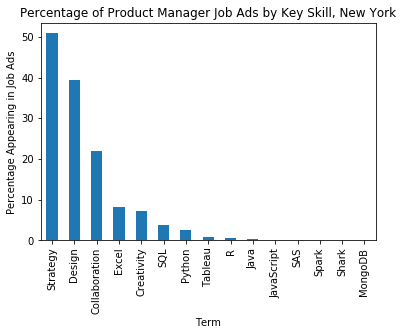

In [49]:
skills_info(city = 'New York', state = 'NY')